In [33]:
import pandas as pd
import os

papers = pd.read_csv(
    "./rawData/sampler_10ktexts_perdecade.ALL2.tsv",
    sep='\t',
    names=["timePeriod", "index", "rawText"]
)

papers.head()

,timePeriod,index,rawText
0,180X.POS.rand,1,The_DT hon_NN ._SENT
1,180X.POS.rand,2,The_DT gallant_JJ general_NN who_WP commanded_...
2,180X.POS.rand,3,"But_CC ,_, Mr._NP Pitt_NP said_VBD ,_, he_PP d..."
3,180X.POS.rand,4,"And_CC Dr._NP Hussey_NP ,_, who_WP informs_VBZ..."
4,180X.POS.rand,5,In_IN former_JJ times_NNS and_CC in_IN former_...


In [34]:
papers['timePeriod'] = papers['timePeriod'].map(lambda x: x.rstrip('X.POS.rand'))
papers['timePeriod'] = papers['timePeriod'].astype(str) + '0'
papers.head()

,timePeriod,index,rawText
0,1800,1,The_DT hon_NN ._SENT
1,1800,2,The_DT gallant_JJ general_NN who_WP commanded_...
2,1800,3,"But_CC ,_, Mr._NP Pitt_NP said_VBD ,_, he_PP d..."
3,1800,4,"And_CC Dr._NP Hussey_NP ,_, who_WP informs_VBZ..."
4,1800,5,In_IN former_JJ times_NNS and_CC in_IN former_...


In [35]:
papers['timePeriod'] = pd.to_datetime(papers['timePeriod'], format='%Y')
papers['timePeriod'] = pd.DatetimeIndex(papers['timePeriod']) #.year
papers.head()

,timePeriod,index,rawText
0,1800-01-01,1,The_DT hon_NN ._SENT
1,1800-01-01,2,The_DT gallant_JJ general_NN who_WP commanded_...
2,1800-01-01,3,"But_CC ,_, Mr._NP Pitt_NP said_VBD ,_, he_PP d..."
3,1800-01-01,4,"And_CC Dr._NP Hussey_NP ,_, who_WP informs_VBZ..."
4,1800-01-01,5,In_IN former_JJ times_NNS and_CC in_IN former_...


In [36]:
reducedPapers = papers[papers["timePeriod"].isin(pd.date_range("1800-01-01", "1830-01-01"))]
reducedPapers.head()

,timePeriod,index,rawText
0,1800-01-01,1,The_DT hon_NN ._SENT
1,1800-01-01,2,The_DT gallant_JJ general_NN who_WP commanded_...
2,1800-01-01,3,"But_CC ,_, Mr._NP Pitt_NP said_VBD ,_, he_PP d..."
3,1800-01-01,4,"And_CC Dr._NP Hussey_NP ,_, who_WP informs_VBZ..."
4,1800-01-01,5,In_IN former_JJ times_NNS and_CC in_IN former_...


In [38]:
import pandas as pd
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

stop_words = set(nltk.corpus.stopwords.words('english'))
wn = WordNetLemmatizer()

# Make a copy of the DataFrame to avoid the SettingWithCopyWarning
reducedPapers = reducedPapers.copy()

def preprocess_text(text):
    tokens = [word.split('_')[0] for word in nltk.word_tokenize(text.lower())]
    words = [word for word in tokens if word.isalpha()]
    lemmas = [wn.lemmatize(word) for word in words if word not in stop_words]
    return " ".join(lemmas)

reducedPapers['processedText'] = reducedPapers['rawText'].apply(preprocess_text)

reducedPapers.head()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sandr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sandr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sandr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,timePeriod,index,rawText,processedText
0,1800-01-01,1,The_DT hon_NN ._SENT,hon
1,1800-01-01,2,The_DT gallant_JJ general_NN who_WP commanded_...,gallant general commanded well knew reinforcem...
2,1800-01-01,3,"But_CC ,_, Mr._NP Pitt_NP said_VBD ,_, he_PP d...",pitt said doubted whether would necessary inse...
3,1800-01-01,4,"And_CC Dr._NP Hussey_NP ,_, who_WP informs_VBZ...",hussey informs u romish bishop waterford appoi...
4,1800-01-01,5,In_IN former_JJ times_NNS and_CC in_IN former_...,former time former war invasion often threaten...


In [39]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
#embeddings = model.encode(reducedPapers['processedText'], show_progress_bar=True)
embeddings = model.encode(reducedPapers['processedText'], show_progress_bar=True)

Batches:   0%|          | 0/916 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [26]:

import umap
umap_embeddings = umap.UMAP(n_neighbors=15,
                            n_components=5,
                            metric='cosine').fit_transform(embeddings)

In [27]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean',
                          cluster_selection_method='eom').fit(umap_embeddings)

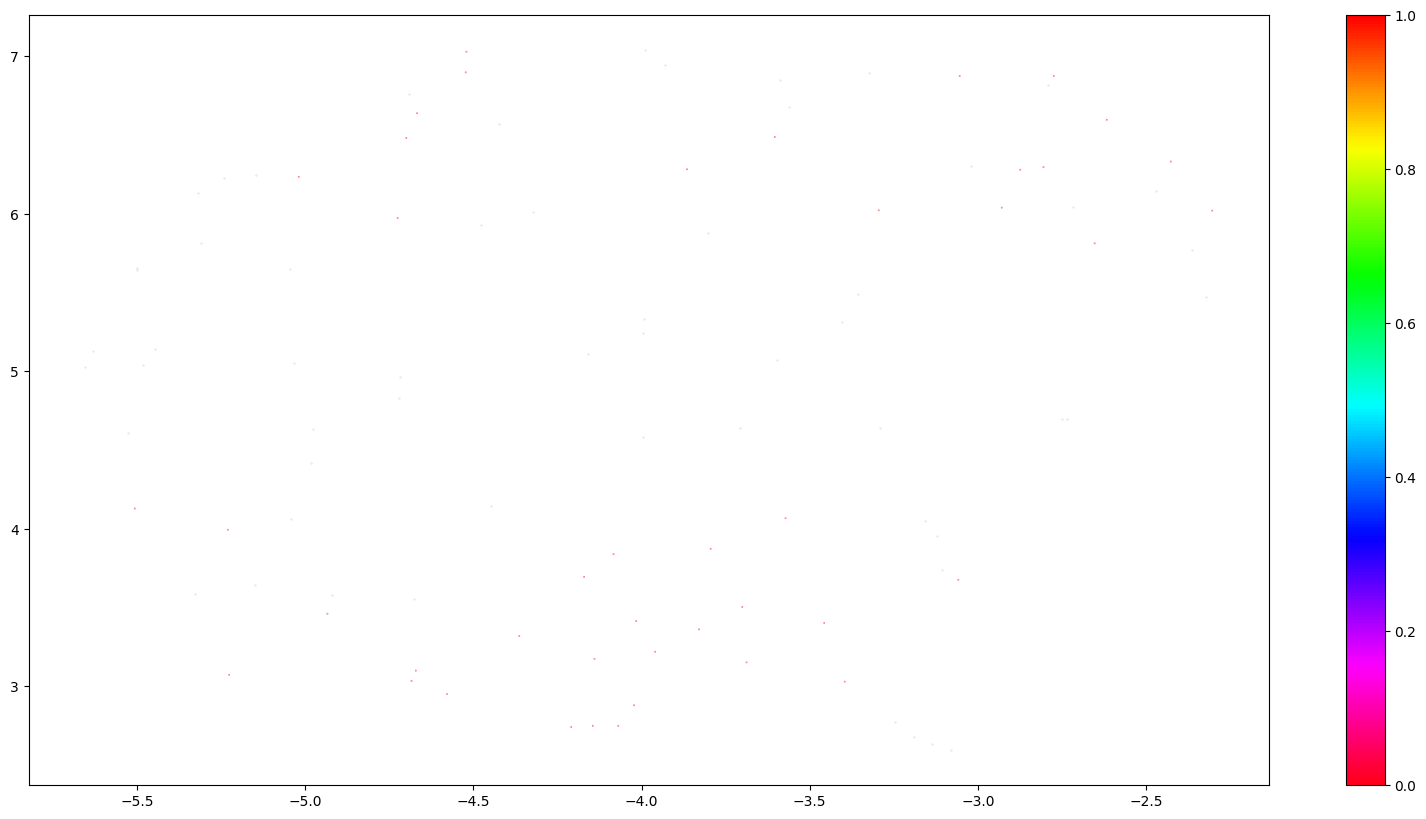

In [28]:
import matplotlib.pyplot as plt

# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

In [29]:
docs_df = pd.DataFrame(reducedPapers['processedText'], columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [30]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(reducedPapers['processedText']))

In [31]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

AttributeError: 'CountVectorizer' object has no attribute 'get_feature_names'

In [32]:
for i in range(20):
    # Calculate cosine similarity
    similarities = cosine_similarity(tf_idf.T)
    np.fill_diagonal(similarities, 0)

    # Extract label to merge into and from where
    topic_sizes = docs_df.groupby(['Topic']).count().sort_values("Doc", ascending=False).reset_index()
    topic_to_merge = topic_sizes.iloc[-1].Topic
    topic_to_merge_into = np.argmax(similarities[topic_to_merge + 1]) - 1

    # Adjust topics
    docs_df.loc[docs_df.Topic == topic_to_merge, "Topic"] = topic_to_merge_into
    old_topics = docs_df.sort_values("Topic").Topic.unique()
    map_topics = {old_topic: index - 1 for index, old_topic in enumerate(old_topics)}
    docs_df.Topic = docs_df.Topic.map(map_topics)
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

    # Calculate new topic words
    m = len(reducedPapers['processedText'])
    tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m)
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)

topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

NameError: name 'cosine_similarity' is not defined